In [1]:
# Requirement
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv

# データパス
`digit`直下にあるファイルを用いる。

`digit_train*.csv`:訓練用標本

`digit_test*.csv`:テスト標本

In [2]:
digit_path = "./digit"
train_data = glob.glob(digit_path+"/"+"*train*")
test_data = glob.glob(digit_path+"/"+"*test*")

In [3]:
print("訓練用データ%s" % train_data)
print("テスト用データ%s" % test_data)

訓練用データ['./digit\\digit_train0.csv', './digit\\digit_train1.csv', './digit\\digit_train2.csv', './digit\\digit_train3.csv', './digit\\digit_train4.csv', './digit\\digit_train5.csv', './digit\\digit_train6.csv', './digit\\digit_train7.csv', './digit\\digit_train8.csv', './digit\\digit_train9.csv']
テスト用データ['./digit\\digit_test0.csv', './digit\\digit_test1.csv', './digit\\digit_test2.csv', './digit\\digit_test3.csv', './digit\\digit_test4.csv', './digit\\digit_test5.csv', './digit\\digit_test6.csv', './digit\\digit_test7.csv', './digit\\digit_test8.csv', './digit\\digit_test9.csv']


In [4]:
train_digits = []
for train_data_i in train_data:
    with open(train_data_i) as f:
        print(train_data_i)
        reader = csv.reader(f)
        digit = [list(map(float, row)) for row in reader]
        train_digits.append(digit[:][:])     
train_digits = np.array(train_digits)

test_digits = []
for test_data_i in test_data:
    with open(test_data_i) as f:
        print(test_data_i)
        reader = csv.reader(f)
        digit = [list(map(float,row)) for row in reader]
        test_digits.append(digit[:][:])
test_digits = np.array(test_digits)

print("訓練用データ{}".format(train_digits.shape))#(文字数,個数/1文字, データ数/1文字)
print("テスト用データ{}".format(test_digits.shape))


./digit\digit_train0.csv
./digit\digit_train1.csv
./digit\digit_train2.csv
./digit\digit_train3.csv
./digit\digit_train4.csv
./digit\digit_train5.csv
./digit\digit_train6.csv
./digit\digit_train7.csv
./digit\digit_train8.csv
./digit\digit_train9.csv
./digit\digit_test0.csv
./digit\digit_test1.csv
./digit\digit_test2.csv
./digit\digit_test3.csv
./digit\digit_test4.csv
./digit\digit_test5.csv
./digit\digit_test6.csv
./digit\digit_test7.csv
./digit\digit_test8.csv
./digit\digit_test9.csv
訓練用データ(10, 500, 256)
テスト用データ(10, 200, 256)


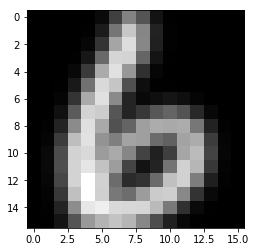

In [5]:
x = train_digits[6,30,:]
plt.imshow(x.reshape(16, 16), 'gray')

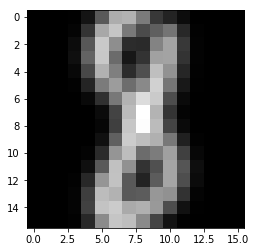

In [6]:
x_test = test_digits[8, 20, :]
plt.imshow(x_test.reshape(16,16), 'gray')

## テストデータ生成

In [7]:
def generate_data(data, digit1, digit2):
    """1対他 or 1対1のためにデータを成形
    1対他---digit1:500個
            digit2:500*9個
    1対1---digit1:500個
            digit2:500個
    
    Arg:
        data(ndarray(int, int, float)) ⇒ndarray(文字(0~9), index(0~499 len=500), データ(len=256))
        digit1(int) 文字
        digit2(list(int)) 文字(1でもリスト格納)
        
    Return:
        x(ndarray(int, float)) concatされた配列 shape(500*n, 256) nは1対他(n=10)or1対1(n=2)により異なる。
        y(ndarray(int⇒1or-1)) xに対応するラベル
    """
    x = np.concatenate([data[digit1, :, :], data[digit2,:,:].reshape(-1, data.shape[2])], axis=0)#shape(500*n, 256)
    digit2_num = data.shape[1]*len(digit2)
    y = np.concatenate([np.ones(data.shape[1]), -np.ones(digit2_num)])#shape=shape(x)
    
    return x, y

# 訓練用関数

In [8]:
def get_gauss_kernel(x1_vec, x2_vec, h=10.):
    """ベクトルに対してガウスカーネルmatの成分を取得する
    Arg:
        x1_vec(ndarray(float)) ガウスカーネルの引数1 shape=(256)
        x2_vec(ndarray(float)) 引数2 shape=(x1_vec.shape)
        h(float) ガウス幅 default=10.0
        
    Return:
        k(float) ガウスカーネルマトリックスの1成分
    """
    return np.exp(-np.linalg.norm(x1_vec-x2_vec)**2/(2*h**2))
     
def get_design_mat(x1, x2, h=10.):
    """今回はガウスカーネルでデザインマトリックスを生成する。
    Arg: x1(ndarray(list(float))) 引数1 shape=(500n, 256)
        x2(ndarray(ist(float))) 引数2 shape=(500n, 256)
        h(float) ガウス幅
    
    Return:
        K(ndarray(float, float)) shape=(500*n, 500*n)多分
    """
    #print(x1.shape)
    #print(x1[:,None].shape)
    #print(x2.shape)
    #print(x2[None].shape)
    n = x1.shape[0] #=len(K_mat) = x2.shape[0]
    K_mat = np.empty([n,n])
    for i in range(n):
        for j in range(n):
            K_mat[i,j] = get_gauss_kernel(x1[i, :], x2[j,:])
    #print(K_mat.shape) #正方行列になっていることの確認
    return K_mat

def get_optim_param(K, y, regulater=0.1):
    """最小二乗回帰により最適パラメータを取得。
    Arg:
        K(ndarray(float, float)) デザインマトリックス
        y(ndarray(int⇒1or-1)) サンプルのy座標
        regulater(float) レギュレータ。solveかけたときに発散するのを防ぐ。
    
    Return:
        theta(ndarray(float)) 回帰によるパラメータ
    """
    theta = np.linalg.solve(np.dot(K,K)+regulater*np.eye(len(y)), K.T.dot(y))
    #print(theta.shape) #=len(y)
    return theta

def train(train_digits_data, target_digit):
    """訓練をまとめた関数。
    Arg:
        train_digits_data(ndarray(float)) 訓練用データ全部=train_digits,
            shape=(10, 500n, 256)
        target_digit(int) 教師用ラベル
    
    Return:
        x(ndarray(float)) generateされた訓練データ shape=(500n, 256)
        これは分類するタイミングで使う。
        theta(ndarray) 訓練されたパラメータ shape=(500n)←=shape(x)[0]
    """
    other_digits = [n for n in range(10)]
    other_digits.remove(target_digit)
    x, y = generate_data(train_digits_data, target_digit, other_digits)
    K_mat = get_design_mat(x, x)
    theta = get_optim_param(K_mat, y)
    return x, theta

# 予測用関数
訓練用関数で得た$\theta$を使う

In [9]:
def predict(x, test_digit, hat_theta):
    """thetaからtargetラベルごとのtest_dataを分類する。
    Arg:
        x(ndarray(float)) generateされたパラム
            shape=(500n, 256)
        test_digit(ndarray(float)) generateされたテストパラム
            shape=(m, 256)
        hat_theta(ndarray(float)) 訓練されたparm shape(500n)
        
    Return:
        Y(ndarray(float)) 予測データ shape=m
    """
    #test_data(ndarray(float)) targetに対応するdigitの集合
    Y = np.empty(test_digit.shape[0])
    for j in range(test_digit.shape[0]):#m
        f_theta = 0
        for i in range(x.shape[0]):#500n
            f_theta += hat_theta[i]*get_gauss_kernel(x[i, :], test_digit[j,:])
        Y[j] = f_theta
    return Y


def get_valid_matrix(train_data, test_digits, hat_theta):
    """検証用マトリックスの作成。
    とりあえず2×2でやってみる
    """
    valid_mat = np.empty((2,2))
    for i in range(2):
        test_data = test_digits[i,:,:] #test_digitsのうち適切なindexをpick
        predictions = predict(train_data, test_data, hat_theta)
        valid_mat[i][0] = np.sum(np.where(predictions>0., 1, 0))
        valid_mat[i][1] = np.sum(np.where(predictions<=0., 1, 0))
        
    return valid_mat

# 分類してみる。

In [10]:
digits = [0,1,2,3,4,5,6,7,8,9]
x_c = []
theta_c = []
valid_mat = np.zeros([len(digits),len(digits)])#正解ラベル, 予測ラベル

for class_digit in digits:#クラスごとにfを生成する。
    x, theta = train(train_digits, class_digit)
    x_c.append(x)
    theta_c.append(theta)
    print("{} is over".format(class_digit))
x_c = np.array(x_c)
theta_c = np.array(theta_c)

0 is over
1 is over
2 is over
3 is over
4 is over
5 is over
6 is over
7 is over
8 is over
9 is over


In [11]:
print(x_c.shape)
print(theta_c.shape)

(10, 5000, 256)
(10, 5000)


In [12]:
for target_digit in digits:#目標のdigitごとに正解判別を行う
    test_digit_group = test_digits[target_digit]
    Y_pred_all_class = np.empty([len(digits), test_digit_group.shape[0]])
    for class_digit in digits:#fの探査
        x = x_c[class_digit,:,:]
        theta = theta_c[class_digit,:]
        Y_pred = predict(x, test_digit_group, theta)
        Y_pred_all_class[class_digit] = Y_pred
    validation = np.argmax(Y_pred_all_class, axis=0)
    print("pred-{} is over".format(target_digit))
    for i in digits:
        valid_mat[target_digit, i] = np.sum(np.where(validation==i, 1, 0))
print(valid_mat)

pred-0 is over
pred-1 is over
pred-2 is over
pred-3 is over
pred-4 is over
pred-5 is over
pred-6 is over
pred-7 is over
pred-8 is over
pred-9 is over
[[197.   0.   1.   0.   0.   0.   2.   0.   0.   0.]
 [  0. 199.   1.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 193.   0.   5.   0.   0.   1.   1.   0.]
 [  0.   0.   0. 192.   0.   4.   0.   2.   2.   0.]
 [  0.   1.   0.   0. 190.   0.   4.   0.   0.   5.]
 [  2.   0.   1.   4.   2. 187.   0.   0.   0.   4.]
 [  1.   0.   2.   0.   1.   1. 195.   0.   0.   0.]
 [  0.   1.   1.   0.   3.   0.   0. 188.   1.   6.]
 [  2.   0.   1.   5.   0.   2.   0.   0. 187.   3.]
 [  0.   0.   0.   0.   1.   0.   0.   1.   2. 196.]]


In [13]:
(197+199+193+192+190+187+195+188+187+196)/2000

0.962

In [14]:
197+199+193+192+190+187+195+188+187+196

1924